In [42]:
#%matplotlib inline
import argparse
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
try: 
    from google.colab import files
    print("Running on Google Colab")
except ImportError: pass


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [48]:
# Root directory for dataset
dataroot = "./data/train/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

n_classes = len(os.listdir(dataroot))
print("Number of classes: ", n_classes)

Number of classes:  11


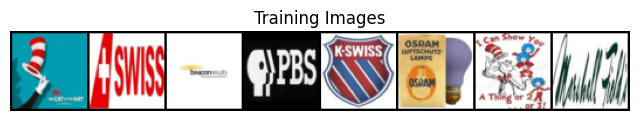

In [49]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [50]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Conditional Generator**

In [63]:
import torch
import torch.nn as nn

class ConditionalGenerator(nn.Module):
    def __init__(self, ngpu, n_classes):
        super(ConditionalGenerator, self).__init__()
        self.ngpu = ngpu
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.main = nn.Sequential(
            # Input is Z concatenated with label, going into a convolution
            nn.ConvTranspose2d( nz + n_classes, ngf * 8, 4, 1, 0, bias=False),
            #nn.ConvTranspose2d(nc + n_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        # Embed labels
        #print("labels shape: ", labels.shape)
        labels = self.label_emb(labels)
        
        # Reshape labels to be [batch_size, embedding_size, 1, 1]
        labels = labels.view(labels.size(0), -1, 1, 1)
        
        # Expand labels to have the same spatial dimensions as z
        labels = labels.expand(-1, -1, z.size(2), z.size(3))
        #print("z shape: ", z.shape)
        
        # Concatenate labels and z to form the input
        input = torch.cat([z, labels], 1)
        #print(input.shape)
        
        return self.main(input)




*test generator*

In [64]:
# Create an instance of the generator
netG = ConditionalGenerator(ngpu=1, n_classes=n_classes)

# Generate a batch of noise vectors and labels
#batch_size = 16

for i, (data, labels) in enumerate(dataloader):
    #noise = data
    noise = torch.randn(batch_size, nz, 1, 1)
    labels = torch.randint(0, n_classes, (batch_size,))
    print("LABEL source", labels.shape)
    print("NOISE source", noise.shape)
    # Move tensors to GPU if available
    if torch.cuda.is_available():
        netG.cuda()
        noise = noise.cuda()
        labels = labels.cuda()

    # Generate images from the noise vectors and labels
    with torch.no_grad():
        generated_images = netG(noise, labels)

        print("Generated images:", generated_images.shape) 
    if i == 5:
        break

LABEL source torch.Size([8])
NOISE source torch.Size([8, 100, 1, 1])
Generated images: torch.Size([8, 3, 64, 64])
LABEL source torch.Size([8])
NOISE source torch.Size([8, 100, 1, 1])
Generated images: torch.Size([8, 3, 64, 64])
LABEL source torch.Size([8])
NOISE source torch.Size([8, 100, 1, 1])
Generated images: torch.Size([8, 3, 64, 64])
LABEL source torch.Size([8])
NOISE source torch.Size([8, 100, 1, 1])
Generated images: torch.Size([8, 3, 64, 64])
LABEL source torch.Size([8])
NOISE source torch.Size([8, 100, 1, 1])
Generated images: torch.Size([8, 3, 64, 64])
LABEL source torch.Size([8])
NOISE source torch.Size([8, 100, 1, 1])
Generated images: torch.Size([8, 3, 64, 64])


In [54]:
# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)
#netG.load_state_dict(torch.load("generator_model.pth"))
# Print the model
print(netG)

ConditionalGenerator(
  (label_emb): Embedding(11, 11)
  (main): Sequential(
    (0): ConvTranspose2d(14, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=

**Conditional Discriminator**

In [55]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ngpu, n_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.main = nn.Sequential(
            # Input is (nc + n_classes) x 64 x 64
            nn.Conv2d(nc + n_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Other layers remain the same...
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        # Embed labels and expand to the same size as x
        labels = self.label_emb(labels)
        labels = labels.view(labels.size(0), labels.size(1), 1, 1)
        labels = labels.expand(labels.size(0), labels.size(1), x.size(2), x.size(3))
        
        # Concatenate labels with images along the channel dimension
        x = torch.cat([x, labels], dim=1)
        
        # Forward pass
        return self.main(x)



*test code*

In [56]:
import torch

# Hyperparameters
#ndf = 64       # Size of feature maps in discriminator
#nc = 3         # Number of channels in the input image
#n_classes = 10 # Number of classes or conditions

# Create an instance of the discriminator
netD = ConditionalDiscriminator(ngpu=1, n_classes=n_classes)

# Generate a batch of fake images and labels

for i, (data, labels) in enumerate(dataloader):
    fake_images = data
    if i == 10:
        break
print("Noise:", data.shape)
print("Labels:", labels.shape)

# Move tensors to GPU if available
if torch.cuda.is_available():
    netD.cuda()
    fake_images = fake_images.cuda()
    labels = labels.cuda()

# Use the discriminator to get the authenticity score
netD.zero_grad()
output = netD(fake_images, labels)

print("Discriminator output:", output.shape)  # Should be [batch_size, 1, 1, 1]


Noise: torch.Size([8, 3, 64, 64])
Labels: torch.Size([8])
Discriminator output: torch.Size([8, 1, 1, 1])


In [57]:
# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)
#netD.load_state_dict(torch.load("discriminator_model.pth"))
# Print the model
print(netD)

ConditionalDiscriminator(
  (label_emb): Embedding(11, 11)
  (main): Sequential(
    (0): Conv2d(14, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): S

### Loss Functions and Optimizers

In [68]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_labels = torch.randint(0, n_classes, (64,), device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Training**

In [71]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, data_label) in enumerate(dataloader, 0):
        print("data_label: ", data_label.shape)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        print('real_cpu: ', real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        print(label.shape)
        # Forward pass real batch through D
        output = netD(real_cpu, data_label).view(-1)
        # Calculate loss on all-real batch
        print("output: ", output.shape)
        print("label: ", label.shape)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        print("noise: ", noise.shape)
        fake = netG(noise, data_label)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), data_label).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, data_label).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if epoch % 100 == 0:
            torch.save(netG.state_dict(), "generator_model.pth")
            torch.save(netD.state_dict(), "discriminator_model.pth")
            try:    
                files.download('generator_model.pth')
                files.download('discriminator_model.pth')
            except: print("colab.files not imported")

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
data_label:  torch.Size([8])
real_cpu:  torch.Size([8, 3, 64, 64])
torch.Size([8])
output:  torch.Size([8])
label:  torch.Size([8])
noise:  torch.Size([8, 100, 1, 1])
[0/1000][0/137]	Loss_D: 0.8607	Loss_G: 2.0483	D(x): 0.6780	D(G(z)): 0.3279 / 0.1503
colab.files not imported
data_label:  torch.Size([8])
real_cpu:  torch.Size([8, 3, 64, 64])
torch.Size([8])
output:  torch.Size([8])
label:  torch.Size([8])
noise:  torch.Size([8, 100, 1, 1])
colab.files not imported
data_label:  torch.Size([8])
real_cpu:  torch.Size([8, 3, 64, 64])
torch.Size([8])
output:  torch.Size([8])
label:  torch.Size([8])
noise:  torch.Size([8, 100, 1, 1])
colab.files not imported
data_label:  torch.Size([8])
real_cpu:  torch.Size([8, 3, 64, 64])
torch.Size([8])
output:  torch.Size([8])
label:  torch.Size([8])
noise:  torch.Size([8, 100, 1, 1])
colab.files not imported
data_label:  torch.Size([8])
real_cpu:  torch.Size([8, 3, 64, 64])
torch.Size([8])
output:  torch.Size([8])
label:  torch.

KeyboardInterrupt: 

**Results**

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real images vs Generated**

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [93]:
netG.load_state_dict(torch.load('/Users/bastianchuttarsing/Downloads/generator_model400.pth',map_location=torch.device('cpu')))
netD.load_state_dict(torch.load('/Users/bastianchuttarsing/Downloads/discriminator_model400.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

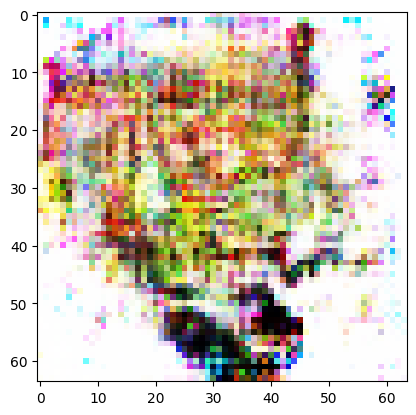

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Your device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Generate noise tensor
batch_size = 1  # Generate one image
noise_dim = 100
noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

# Generate label tensor
fixed_labels = torch.tensor([8], device=device)

# Generate image with Generator (assuming netG is your trained generator model)
with torch.no_grad():
    generated_image_tensor = netG(noise, fixed_labels).detach().cpu()

# Convert PyTorch tensor to NumPy array
generated_image_array = generated_image_tensor[0].numpy()

# Convert values to uint8 type
generated_image_array = ((generated_image_array + 1) / 2.0 * 255).astype('uint8')

# Rearrange dimensions from CxHxW to HxWxC
generated_image_array = np.transpose(generated_image_array, (1, 2, 0))

# Display image using matplotlib
plt.imshow(generated_image_array)
plt.show()
